In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch, transformers
plt.style.use('ggplot')

import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')
#set seed for reproducibility
seed=42
#keras
import tensorflow as tf
from tensorflow import keras

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\paart\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\paart\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# Read in data
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df_tester = pd.read_csv('data.csv')
print(df.shape)

(5842, 2)


In [3]:
df_tester = df_tester.head(5000)
df =df.head(5000)

In [4]:
df.info

<bound method DataFrame.info of                                                Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
4995  $GILD Sandbagged the guidance so the can use t...   neutral
4996  fi is developing cooperation in keyword advert...  positive
4997  The contract value amounts to about EUR11m , t...   neutral
4998  Kalnapilio-Tauro Grupe ( Kalnapilis-Tauras Gro...  positive
4999  A total of 185 Wonderware Certified SIs are av...   neutral

[5000 rows x 2 columns]>

In [5]:
df.drop_duplicates(subset='Sentence',inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4613 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   4613 non-null   object
 1   Sentiment  4613 non-null   object
dtypes: object(2)
memory usage: 108.1+ KB


In [7]:
df_tester.drop_duplicates(subset='Sentence',inplace=True)

In [8]:
df_tester.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4613 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   4613 non-null   object
 1   Sentiment  4613 non-null   object
dtypes: object(2)
memory usage: 108.1+ KB


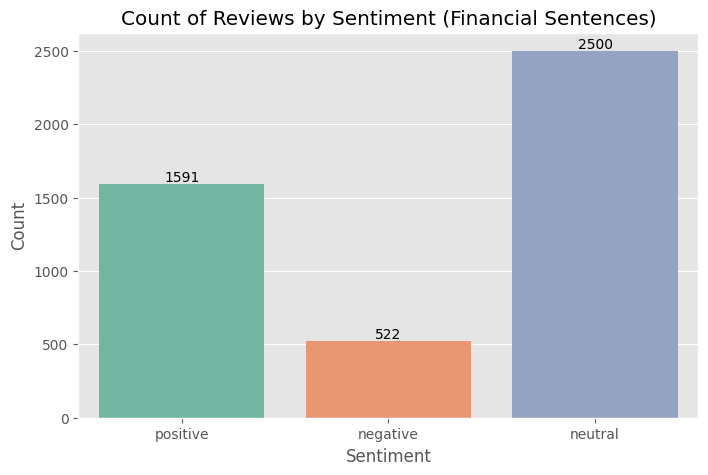

In [9]:
# Create a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Sentiment', palette='Set2')
plt.title('Count of Reviews by Sentiment (Financial Sentences)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Annotate the bars with counts
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

In [10]:
#data processing
import re, string
import emoji
import nltk

from tqdm.notebook import tqdm
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [11]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS
#Emojis will be left into the tweets as cardiffnlp is fine tuned

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)
    

In [12]:
texts_new = []
for t in df.Sentence:
    if pd.notna(t):  # Check if 't' is not NaN
        cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(str(t)))))
        texts_new.append(cleaned_text)
    else:
        texts_new.append("")  # Replace NaN with an empty string

In [13]:

texts_new_test = []
for t in df_tester.Sentence:
    if pd.notna(t):  # Check if 't' is not NaN
        cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(str(t)))))
        texts_new_test.append(cleaned_text)
    else:
        texts_new_test.append("")  # Replace NaN with an empty string
    print("Processed:", t)
    

Processed: The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
Processed: $ESI on lows, down $1.50 to $2.50 BK a real possibility
Processed: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Processed: According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .
Processed: The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .
Processed: $SPY wouldn't be surprised to see a green close
Processed: Shell's $70 Billion BG Deal Meets Shareholder Skepticism
Processed: SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008

In [14]:

print("Length of texts_new:", len(texts_new))
print("Length of texts_new_test:", len(texts_new_test))
print("Number of rows in df:", len(df))
print("Number of rows in df_test:", len(df_tester))
print("Columns in df:", df.columns)
print("Columns in df_test:", df_tester.columns)


Length of texts_new: 4613
Length of texts_new_test: 4613
Number of rows in df: 4613
Number of rows in df_test: 4613
Columns in df: Index(['Sentence', 'Sentiment'], dtype='object')
Columns in df_test: Index(['Sentence', 'Sentiment'], dtype='object')


In [15]:
df['text_clean'] = df['Sentence']
df_tester['text_clean'] = df_tester['Sentence']

In [16]:
df['text_clean'].head()

0    The GeoSolutions technology will leverage Bene...
1    $ESI on lows, down $1.50 to $2.50 BK a real po...
2    For the last quarter of 2010 , Componenta 's n...
3    According to the Finnish-Russian Chamber of Co...
4    The Swedish buyout firm has sold its remaining...
Name: text_clean, dtype: object

In [17]:
df_tester['text_clean'].head()

0    The GeoSolutions technology will leverage Bene...
1    $ESI on lows, down $1.50 to $2.50 BK a real po...
2    For the last quarter of 2010 , Componenta 's n...
3    According to the Finnish-Russian Chamber of Co...
4    The Swedish buyout firm has sold its remaining...
Name: text_clean, dtype: object

In [18]:
df['text_clean'][1:8].values

array(['$ESI on lows, down $1.50 to $2.50 BK a real possibility',
       "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
       'According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .',
       'The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .',
       "$SPY wouldn't be surprised to see a green close",
       "Shell's $70 Billion BG Deal Meets Shareholder Skepticism",
       'SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .'],
      dtype=object)

In [19]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [20]:
df['text_len'] = text_len

In [21]:
text_len_test = []
for text in df_tester.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [22]:
df_tester['text_len'] = text_len_test

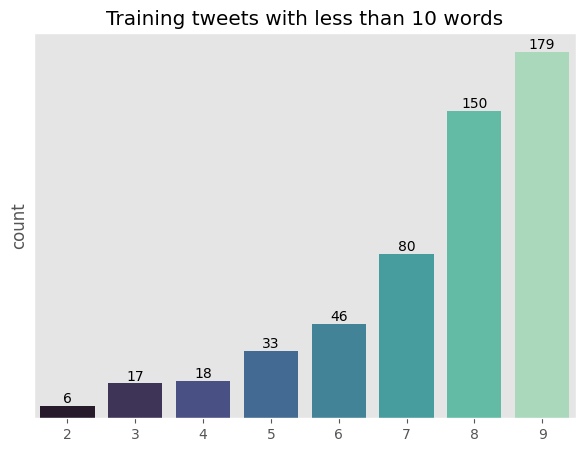

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [24]:
# Function to count words in a text
def count_words(text):
    words = text.split()
    return len(words)

# Apply the function to the 'Sentence' column and store the word counts in a new column
df['Word_Count'] = df['Sentence'].apply(count_words)

# Print sentences with less than 5 words
print("Sentences with less than 5 words:")
short_sentences = df[df['Word_Count'] < 5]['Sentence']
for sentence in short_sentences:
    print(sentence)

Sentences with less than 5 words:
All are welcome .
$YANG Double bottom 5.2
$TSLA recall
R&D Loan ) .
Just went long $ILMN
All rights reserved .
$DARA breaking out
long $AAPL
It 's not .
$TSPT  long 8.00
$WYNN big bounce
$SPY weak close
Long $X 24.62
$DCTH Near HOD
@pierrules: $SIRI LONG!!
$AAPL $131 rally mode
Welcome !
$ELN longs...congrats...another HOD
$NUGT longer term bullish
$AMCN pushing highs
$NUGT Gold above 1400...wow
$BBRY nice bounce
$CTRP breaking out https://t.co/Z2je3rTKch
$SAVE long. https://t.co/yEJuS9cMlC
$brcm raises revenue forecast
Long $PCLN
Timberrrr $TSLA https://t.co/MRBgfDHHVa
Net investment income
$BWLD bearish engulfing candle
$CHRM Loooooongggggg base
NWC ANALYSIS :
$FB trending nicely, intraday.
$GTE LONG at 7.44
$amzn breaking
Status : Agreed
$PLUG bear raid
Registration is required .
$AAPL 620 resistance area
$AAPL short some 592.49
$YHOO making new HOD
$NEON oversold


In [25]:
'''
text_len_test = []

for text in df_tester.clean_comment:
    if isinstance(text, str):  # Check if the text is a non-empty string
        tweet_len = len(text.split())
        text_len_test.append(tweet_len)
    else:
        text_len_test.append(0)  # Handle missing or empty values

max_length_test = max(text_len_test)
print(max_length_test)
'''

'\ntext_len_test = []\n\nfor text in df_tester.clean_comment:\n    if isinstance(text, str):  # Check if the text is a non-empty string\n        tweet_len = len(text.split())\n        text_len_test.append(tweet_len)\n    else:\n        text_len_test.append(0)  # Handle missing or empty values\n\nmax_length_test = max(text_len_test)\nprint(max_length_test)\n'

In [26]:
df_tester['text_len'] = text_len_test

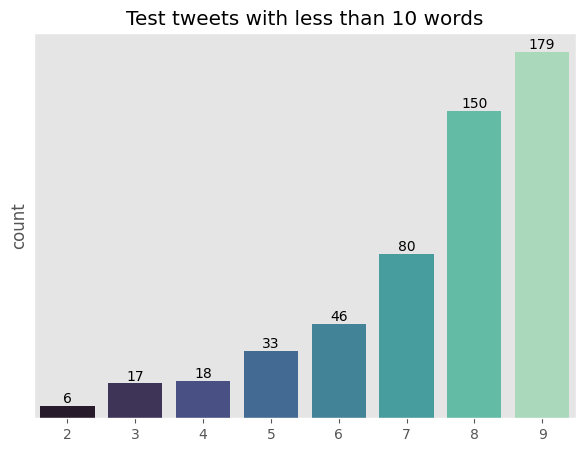

In [27]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_tester[df_tester['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [28]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_tester.shape}")

 DF SHAPE: (4613, 5)
 DF TEST SHAPE: (4613, 4)


In [29]:
df = df[df['text_len'] > 4]

In [30]:
df_tester = df_tester[df_tester['text_len'] > 4]

In [31]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_tester.shape}")

 DF SHAPE: (4572, 5)
 DF TEST SHAPE: (4572, 4)


In [32]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import torch.nn as nn

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
roberta_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=5000, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [34]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 133


In [35]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=140, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 127, TEXT: Alma Media Corporation Press Release 15 March 2010 TYRVAAN SANOMAT AND PAIKALLISSANOMAT BEING BOUGHT BY SUOMEN PAIKALLISSANOMAT Two local papers , Tyrvaan Sanomat and Paikallissanomat , appearing in Sastamala and its neighbouring municipalities , are to be bought by Suomen Paikallissanomat Oy .
INDEX: 2155, TEXT: 3 January 2011 - Scandinavian lenders Sampo Bank ( HEL : SAMAS ) , Pohjola Bank ( HEL : POH1S ) and Svenska Handelsbanken ( STO : SHB A ) have provided a EUR160m ( USD213m ) line of credit to Lemminkainen Oyj ( HEL : LEM1S ) , the Finnish construction firm said on Friday .
INDEX: 2268, TEXT: Body ES Vostok also owns stakes in power sales companies MosenergosbytBody ( RTS : MSSB ) ( 50.9 % ) , Altaienergosbyt ( 100 % ) , Saratovenergo ( RTS : SARE ) Body ( 48.36 % ) and Tambov Power Sales Company ( RTS : TASB ) ( 49.01 % ) , all ofBodywhich it received from the distribution balance .
INDEX: 3512, TEXT: The real estate company posted a net loss of +Ã³  x201a -Â

In [36]:
!pip install langdetect



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\paart\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [37]:
'''
from langdetect import detect, detect_langs, DetectorFactory

# Set the seed for consistent language detection results
DetectorFactory.seed = 0

# Create a function to detect the language of a text and return both the language and text
def detect_language(text):
    try:
        lang = detect(text)
        # Get the probabilities of the top languages
        lang_probs = detect_langs(text)
        return lang, text, lang_probs
    except:
        return 'unknown', text, []

# Apply the language detection function to the 'text' column and create new columns 'language', 'detected_text', and 'lang_probs'
df[['language', 'detected_text', 'lang_probs']] = df['review'].apply(lambda x: pd.Series(detect_language(x)))

# Filter out rows with a single non-English language probability > 0.8 without English
filtered_df = df[
    ~((df['language'] != 'en') & (df['lang_probs'].apply(lambda x: x[0].lang != 'en' and x[0].prob > 0.8)))
]

# Print the non-English text, the detected language, and language probabilities
for index, row in filtered_df.iterrows():
    print(f"Language detected as '{row['language']}' with probabilities:")
    for lang_info in row['lang_probs']:
        print(f"{lang_info.lang}:{lang_info.prob}", end=", ")
    print()
    print(row['detected_text'])
    print('-' * 50)

# Drop the 'language', 'detected_text', and 'lang_probs' columns if you don't need them in your final DataFrame
filtered_df = filtered_df.drop(columns=['language', 'detected_text', 'lang_probs'])
'''

'\nfrom langdetect import detect, detect_langs, DetectorFactory\n\n# Set the seed for consistent language detection results\nDetectorFactory.seed = 0\n\n# Create a function to detect the language of a text and return both the language and text\ndef detect_language(text):\n    try:\n        lang = detect(text)\n        # Get the probabilities of the top languages\n        lang_probs = detect_langs(text)\n        return lang, text, lang_probs\n    except:\n        return \'unknown\', text, []\n\n# Apply the language detection function to the \'text\' column and create new columns \'language\', \'detected_text\', and \'lang_probs\'\ndf[[\'language\', \'detected_text\', \'lang_probs\']] = df[\'review\'].apply(lambda x: pd.Series(detect_language(x)))\n\n# Filter out rows with a single non-English language probability > 0.8 without English\nfiltered_df = df[\n    ~((df[\'language\'] != \'en\') & (df[\'lang_probs\'].apply(lambda x: x[0].lang != \'en\' and x[0].prob > 0.8)))\n]\n\n# Print the 

In [38]:
df.info
df.shape

(4572, 5)

In [39]:
'''
# Set the seed for consistent language detection results
DetectorFactory.seed = 0

# Apply the language detection function to the 'text' column and create new columns 'language', 'detected_text', and 'lang_probs'
df_tester[['language', 'detected_text', 'lang_probs']] = df_tester['review'].apply(lambda x: pd.Series(detect_language(x)))

# Filter out rows with a single non-English language probability > 0.8 without English
filtered_df_tester = df_tester[
    ~((df_tester['language'] != 'en') & (df_tester['lang_probs'].apply(lambda x: x[0].lang != 'en' and x[0].prob > 0.8)))
]

# Print the non-English text, the detected language, and language probabilities for df_tester
for index, row in filtered_df_tester.iterrows():
    print(f"Language detected as '{row['language']}' with probabilities:")
    for lang_info in row['lang_probs']:
        print(f"{lang_info.lang}:{lang_info.prob}", end=", ")
    print()
    print(row['detected_text'])
    print('-' * 50)

# Drop the 'language', 'detected_text', and 'lang_probs' columns if you don't need them in your final DataFrame
filtered_df_tester = filtered_df_tester.drop(columns=['language', 'detected_text', 'lang_probs'])
'''

'\n# Set the seed for consistent language detection results\nDetectorFactory.seed = 0\n\n# Apply the language detection function to the \'text\' column and create new columns \'language\', \'detected_text\', and \'lang_probs\'\ndf_tester[[\'language\', \'detected_text\', \'lang_probs\']] = df_tester[\'review\'].apply(lambda x: pd.Series(detect_language(x)))\n\n# Filter out rows with a single non-English language probability > 0.8 without English\nfiltered_df_tester = df_tester[\n    ~((df_tester[\'language\'] != \'en\') & (df_tester[\'lang_probs\'].apply(lambda x: x[0].lang != \'en\' and x[0].prob > 0.8)))\n]\n\n# Print the non-English text, the detected language, and language probabilities for df_tester\nfor index, row in filtered_df_tester.iterrows():\n    print(f"Language detected as \'{row[\'language\']}\' with probabilities:")\n    for lang_info in row[\'lang_probs\']:\n        print(f"{lang_info.lang}:{lang_info.prob}", end=", ")\n    print()\n    print(row[\'detected_text\'])\n 

In [40]:
df_tester.shape

(4572, 4)

In [41]:
df.shape

(4572, 5)

In [42]:
df_tester.shape
df.shape

(4572, 5)

In [43]:
token_lens_test = []

for txt in df_tester['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=5000, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [44]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 133


In [45]:
token_lens_test = []

for i,txt in enumerate(df_tester['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=5000, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>1000:
        print(f"INDEX: {i}, TEXT: {txt}")

In [46]:
df['Sentiment'].value_counts()

Sentiment
neutral     2490
positive    1566
negative     516
Name: count, dtype: int64

In [47]:
from tqdm.notebook import tqdm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [48]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_oversampler = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [49]:
train_oversampler['Sentiment'].value_counts()

Sentiment
positive    2490
negative    2490
neutral     2490
Name: count, dtype: int64

In [50]:
X = train_oversampler['text_clean'].values
y = train_oversampler['Sentiment'].values

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [52]:
X_tester = df_tester['text_clean'].values
y_tester = df_tester['Sentiment'].values

In [53]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_tester.copy()

In [54]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_tester = ohe.fit_transform(np.array(y_tester).reshape(-1, 1)).toarray()

In [55]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_tester.shape[0]}" )

TRAINING DATA: 6723
VALIDATION DATA: 747
TESTING DATA: 4572


In [56]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

133

In [57]:
MAX_LEN=140

In [58]:
def tokenize_data(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for text in data:
        # Use the tokenizer to tokenize the text
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])
    
    return np.array(input_ids), np.array(attention_masks)

# Tokenize your data
train_input_ids, train_attention_masks = tokenize_data(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_data(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_data(X_tester, MAX_LEN)

In [59]:
def create_model(roberta_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Pass inputs through the RoBERTa model
    outputs = roberta_model(input_ids, attention_mask=attention_masks)

    # Access the logits
    logits = outputs.logits

    # Add classification layer
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(logits)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(opt, loss=loss, metrics=[accuracy])
    return model


In [60]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 140)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 140)]                0         []                            
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246479   ['input_1[0][0]',             
 assification (TFRobertaFor  (loss=None, logits=(None,    39         'input_2[0][0]']             
 SequenceClassification)     3),                                                                  
                              hidden_states=None, atten                                       

In [61]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=3, batch_size=80)

Epoch 1/3
85/85 [==============================] - 4593s 52s/step - loss: 0.5802 - categorical_accuracy: 0.7870 - val_loss: 0.3785 - val_categorical_accuracy: 0.8755
Epoch 2/3
85/85 [==============================] - 5971s 56s/step - loss: 0.3239 - categorical_accuracy: 0.8883 - val_loss: 0.3103 - val_categorical_accuracy: 0.8889
Epoch 3/3
85/85 [==============================] - 6576s 77s/step - loss: 0.2513 - categorical_accuracy: 0.9116 - val_loss: 0.2691 - val_categorical_accuracy: 0.9090


In [64]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

143/143 [==============================] - 430s 3s/step


In [65]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [66]:
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_tester,y_pred_roberta, target_names=['negative', 'neutral', 'positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    negative       0.64      0.99      0.78       516
     neutral       0.99      0.83      0.90      2490
    positive       0.90      0.98      0.94      1566

   micro avg       0.90      0.90      0.90      4572
   macro avg       0.84      0.93      0.87      4572
weighted avg       0.92      0.90      0.90      4572
 samples avg       0.90      0.90      0.90      4572



In [67]:
most_negative_index = np.argmax(result_roberta[:, 0])  # Index with the highest negative sentiment score
most_negative_text = tokenizer.decode(test_input_ids[most_negative_index], skip_special_tokens=True)
most_negative_scores = result_roberta[most_negative_index]
print("Most Negative Text:")
print("Text:", most_negative_text)
print("Sentiment Scores:", most_negative_scores)
most_positive_index = np.argmax(result_roberta[:, 2])  # Index with the highest positive sentiment score
most_positive_text = tokenizer.decode(test_input_ids[most_positive_index], skip_special_tokens=True)
most_positive_scores = result_roberta[most_positive_index]
print("Most Positive Text:")
print("Text:", most_positive_text)
print("Sentiment Scores:", most_positive_scores)
most_neutral_index = np.argmax(result_roberta[:, 1])  # Index with the highest positive sentiment score
most_neutral_text = tokenizer.decode(test_input_ids[most_neutral_index], skip_special_tokens=True)
most_neutral_scores = result_roberta[most_neutral_index]
print("Most Neutral Text:")
print("Text:", most_neutral_text)
print("Sentiment Scores:", most_neutral_scores)


Most Negative Text:
Text: $TSLA recalls 2,700 Model X cars. Stock dropping hard...
Sentiment Scores: [0.98848766 0.00664322 0.00486911]
Most Positive Text:
Text: HELSINKI (Thomson Financial)- Kemira GrowHow swung into profit in its first quarter earnings on improved sales, especially in its fertilizer business in Europe, which is normally stronger during the first quarter.
Sentiment Scores: [0.00271652 0.00538385 0.9918996 ]
Most Neutral Text:
Text: The combined value of the orders is EUR 45mn.
Sentiment Scores: [0.0037189  0.991401   0.00488003]


In [82]:



from sklearn.metrics import confusion_matrix



#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

C:\Users\paart\AppData\Local\Temp\ipykernel_90604\3397344636.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

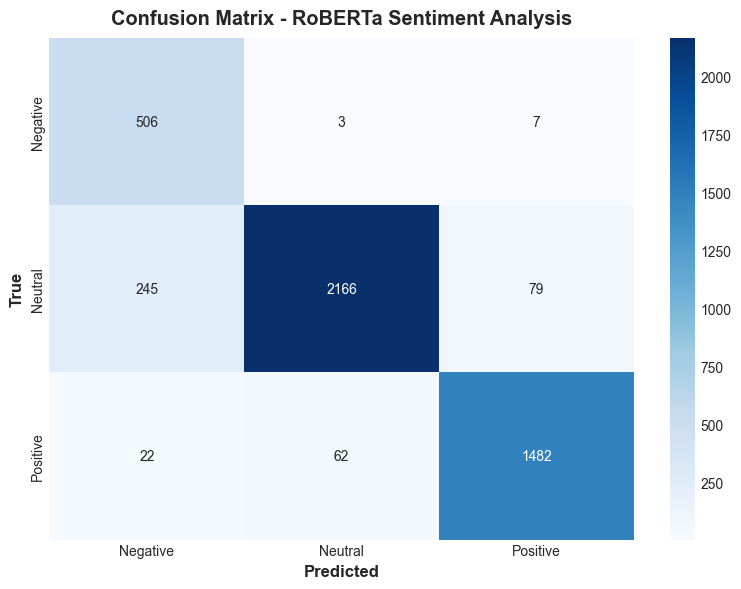

In [85]:
# Convert one-hot encoded predictions back to labels
y_pred_roberta_labels = np.argmax(y_pred_roberta, axis=1)
y_tester_labels = np.argmax(y_tester, axis=1)
# Calculate the confusion matrix
cm = confusion_matrix(y_tester_labels, y_pred_roberta_labels)

# Define class labels
class_labels = ['Negative', 'Neutral', 'Positive']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RoBERTa Sentiment Analysis')
plt.show()

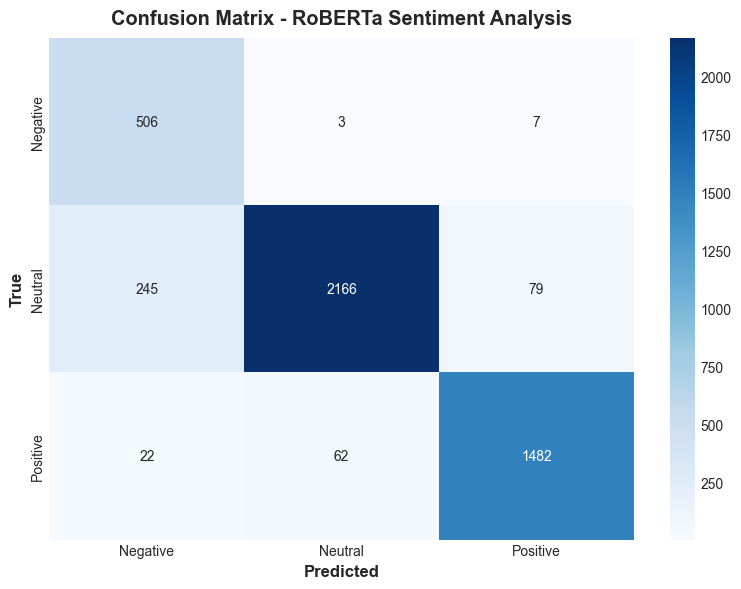

In [80]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'y_pred_roberta' are arrays with your true labels and predicted labels, respectively

# Calculate the confusion matrix
cm = confusion_matrix(y_tester.argmax(1), y_pred_roberta.argmax(1))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RoBERTa Sentiment Analysis')
plt.show()


In [78]:

conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

NameError: name 'conf_matrix' is not defined

In [74]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Convert boolean values to sentiment labels
y_tester_labels = ['positive' if label else 'negative' for label in y_tester]
y_pred_roberta_labels = ['positive' if label else 'negative' for label in y_pred_roberta]

# Calculate accuracy scores
accuracy = accuracy_score(y_tester_labels, y_pred_roberta_labels)

# Print accuracy
print("Accuracy:", accuracy)

# Create a bar plot to visualize accuracy
categories = ['Positive', 'Negative']
accuracies = [accuracy]

plt.figure(figsize=(6, 4))
plt.bar(categories, accuracies, color=['green', 'red'])
plt.xlabel('Sentiment Category')
plt.ylabel('Accuracy')
plt.title('Accuracy of Sentiment Analysis Model')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()